# Introduction

Every successful business runs on data — but the real value comes from understanding what those numbers actually mean.  
In this project, I take a deep dive into the **Superstore sales dataset (2014–2017)** to answer one big question:  
**How can we make smarter decisions to boost profit and growth?**

The dataset includes more than **9,000 transactions** with details about products, customers, sales, profit, and shipping.

**What did I set out to do?**
- Spot the patterns: When do customers buy the most? Which months or seasons matter?
- Find the winners and losers: Which products, regions, and customers are truly profitable — and which are dragging us down?
- Dig into the "why": What really drives profit or loss? (Discounts, shipping, geography, or something else?)
- Predict the future: Can we build a model that accurately forecasts profit for new orders?
- Share clear, practical insights that any manager could act on.

This notebook is more than just charts and numbers — it’s a story:  
how a superstore can use its data to work smarter, not just harder.

---

*Whether you’re a data enthusiast, a business leader, or simply curious, this analysis will guide you step by step from raw data to valuable business lessons. Let’s get started!*


## Imports Libraries

In [135]:
import os

# Kaggle input discovery (safe on local machines)
if os.path.exists("/kaggle/input"):
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            if "superstore" in filename.lower():
                print(os.path.join(dirname, filename))
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

from sklearn.model_selection import KFold, train_test_split, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance


warnings.filterwarnings("ignore")
sns.set_context('notebook', font_scale=1.2)
pd.set_option('display.max_columns', None)


## Load Data

In [ ]:
from repo_utils.pathing import resolve_data_path

DATA_FILE = "Sample - Superstore.csv"

# Local (recommended): put the file in `data/raw/`
# Kaggle fallback: /kaggle/input/superstore-dataset-final/...
data_path = resolve_data_path(DATA_FILE, kaggle_subdir_hint="superstore-dataset-final")

df = pd.read_csv(data_path, encoding="windows-1252")
df


## Initial Data Exploration

In [137]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [139]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [140]:
df.shape

(9994, 21)

## Data Cleaning

# Check missing values & duplicates


In [141]:
# Missing values 
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

We quantify missing values per column to plan imputation or safe drops.

In [142]:
# Remove duplicates
df.duplicated().sum()

0

We remove duplicates to prevent double counting.

# Convert to datetime

In [143]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df.drop_duplicates(inplace=True)

We convert Order Date and Ship Date to datetime, unlocking time‑based analysis and lead‑time metrics.

In [144]:
sales_month_by_period  = (df.set_index('Order Date').resample('M')['Sales'].sum().sort_index())
profit_month_by_period = (df.set_index('Order Date').resample('M')['Profit'].sum().sort_index())


We resample by calendar month to build two key time series:

sales_month_by_period → total sales per month

profit_month_by_period → total profit per month

These series power trend charts, seasonality checks, and forecasting.

In [145]:
kpis = {}
kpis['total_sales']   = float(df['Sales'].sum())
kpis['total_profit']  = float(df['Profit'].sum())
kpis['avg_ship_days'] = (df['Ship Date'] - df['Order Date']).dt.days.clip(lower=0).mean()

kpis['top_months_sales'] = (sales_month_by_period.sort_values(ascending=False)
                                            .head(5).index.strftime('%Y-%m').tolist())
kpis['highest_region'] = df.groupby('Region')['Sales'].sum().idxmax()
kpis['top_category']   = df.groupby('Category')['Sales'].sum().idxmax()

today = df['Order Date'].max() + pd.Timedelta(days=1)
_rfm = df.groupby('Customer ID').agg(
    Recency  = ('Order Date', lambda x: (today - x.max()).days),
    Frequency=('Order ID', 'nunique'),
    Monetary =('Sales', 'sum')
).reset_index()

_rfm['R_Score'] = pd.qcut(_rfm['Recency'], 4, labels=[4,3,2,1])
_rfm['F_Score'] = pd.qcut(_rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
_rfm['M_Score'] = pd.qcut(_rfm['Monetary'], 4, labels=[1,2,3,4])
_rfm[['R_Score','F_Score','M_Score']] = _rfm[['R_Score','F_Score','M_Score']].astype(int)
_rfm['RFM_Sum'] = _rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

def _seg(s):
    if s >= 10: return 'Champions'
    if s >= 8:  return 'Loyal'
    if s >= 6:  return 'Potential'
    return 'At Risk'
_rfm['Segment'] = _rfm['RFM_Sum'].apply(_seg)

rfm_pct = (_rfm['Segment'].value_counts(normalize=True)*100).round(0).astype(int)
for g in ['Champions','Loyal','Potential','At Risk']:
    if g not in rfm_pct: rfm_pct.loc[g] = 0
rfm_pct = rfm_pct[['Champions','Loyal','Potential','At Risk']]

exec_md = f"""
# 📝 Executive Summary

- Strong seasonality with **December spikes**; **Top months:** {", ".join(kpis['top_months_sales'])}.
- **{kpis['highest_region']}** leads by sales; **{kpis['top_category']}** is the top category.
- **Avg. shipping time ≈ {kpis['avg_ship_days']:.2f} days**.
- **Total sales:** {kpis['total_sales']:,.2f} · **Total profit:** {kpis['total_profit']:,.2f}.
- **RFM mix:** Champions {rfm_pct['Champions']}% · Loyal {rfm_pct['Loyal']}% · Potential {rfm_pct['Potential']}% · At Risk {rfm_pct['At Risk']}%.
"""
display(Markdown(exec_md))


# 📝 Executive Summary

- Strong seasonality with **December spikes**; **Top months:** 2017-11, 2016-12, 2017-09, 2017-12, 2014-09.
- **West** leads by sales; **Technology** is the top category.
- **Avg. shipping time ≈ 3.96 days**.
- **Total sales:** 2,297,200.86 · **Total profit:** 286,397.02.
- **RFM mix:** Champions 24% · Loyal 28% · Potential 23% · At Risk 25%.


Categorical Coverage (Category, Region).

# Exploratory Data Analysis (EDA)

## Correlation Matrix

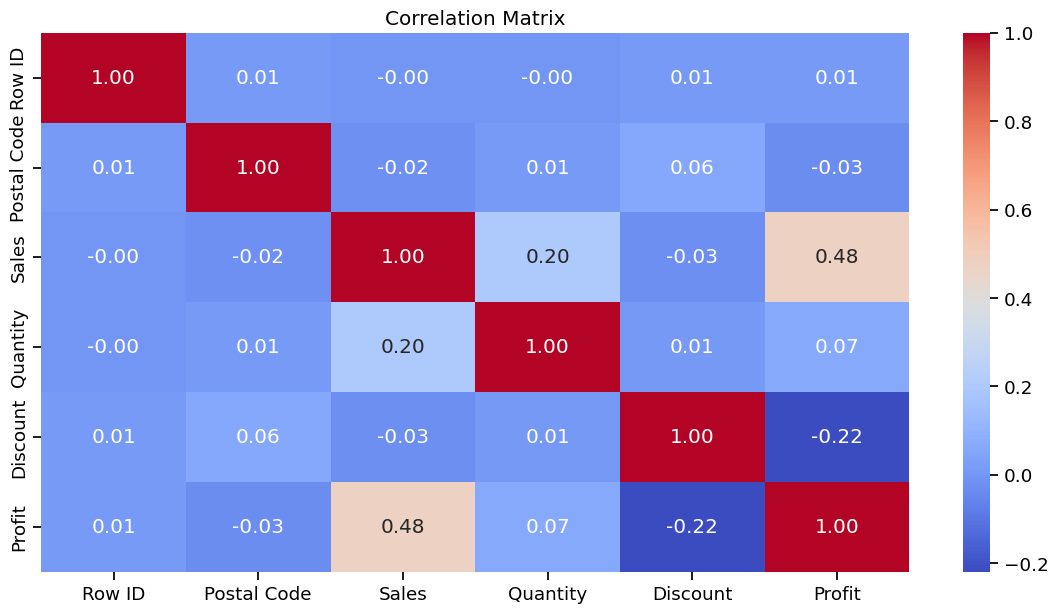

In [146]:
plt.figure(figsize=(14, 7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Correlation heatmap to check relationships.

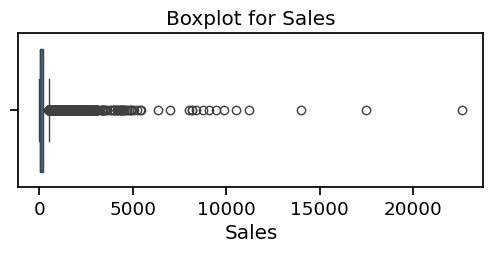

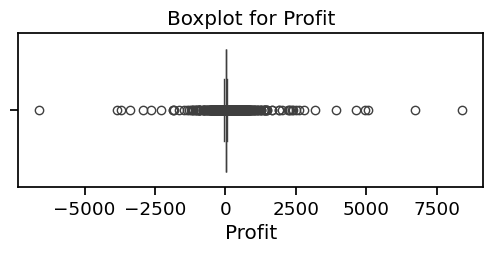

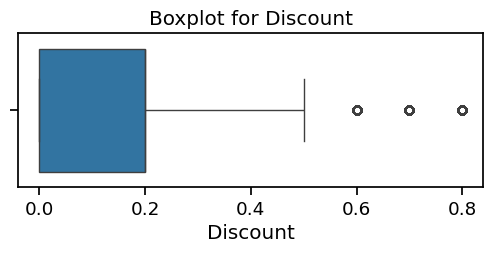

In [147]:
for col in ['Sales', 'Profit', 'Discount']:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

Boxplot to detect profit outliers.

## Monthly Sales Trend

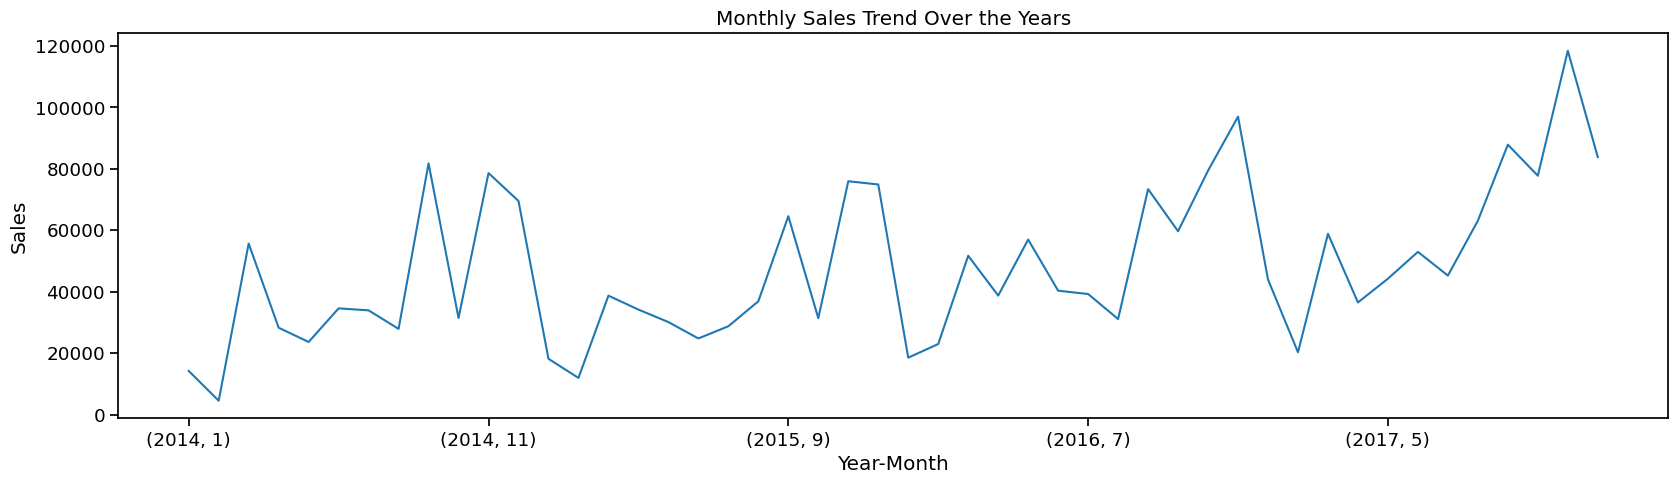

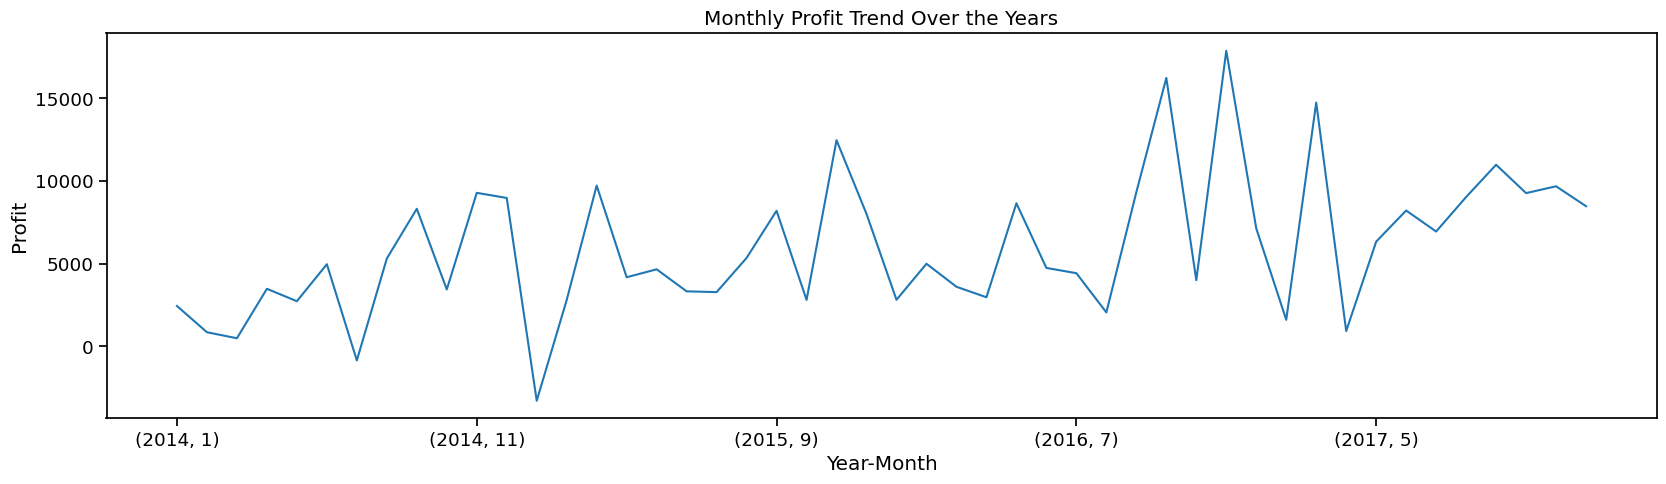

In [148]:
sales_year_month = (df
    .groupby([df['Order Date'].dt.year.rename('Year'),
              df['Order Date'].dt.month.rename('Month')])['Sales']
    .sum()
    .sort_index())

plt.figure(figsize=(20,5))
sales_year_month.plot()
plt.title('Monthly Sales Trend Over the Years')
plt.xlabel('Year-Month'); plt.ylabel('Sales'); plt.show()

profit_year_month = (df
    .groupby([df['Order Date'].dt.year.rename('Year'),
              df['Order Date'].dt.month.rename('Month')])['Profit']
    .sum()
    .sort_index())

plt.figure(figsize=(20,5))
profit_year_month.plot()
plt.title('Monthly Profit Trend Over the Years')
plt.xlabel('Year-Month'); plt.ylabel('Profit'); plt.show()


Monthly sales trend across years.

# Heatmap - Monthly Sales per Year

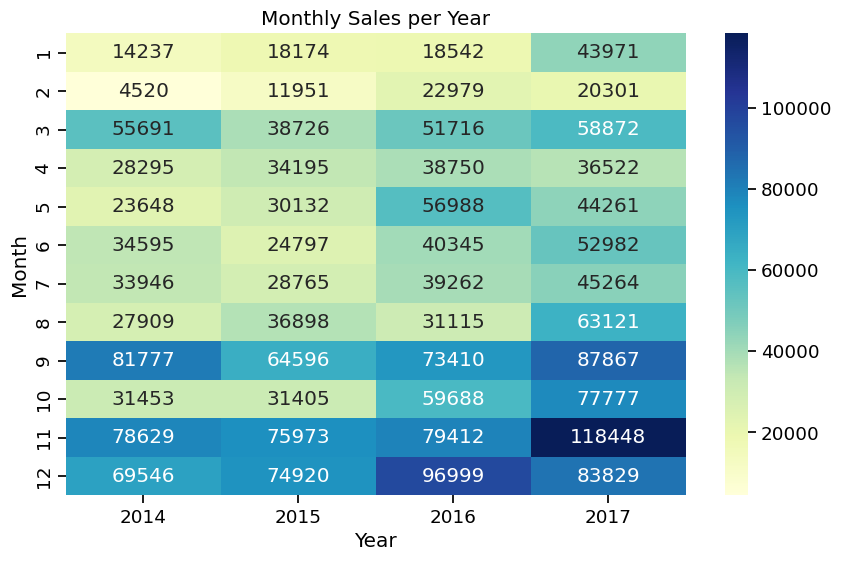

In [149]:
pivot = df.pivot_table(index=df['Order Date'].dt.month, columns=df['Order Date'].dt.year, values='Sales', aggfunc='sum')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Monthly Sales per Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

Compare December across years to check whether holiday uplift is getting stronger or weaker.

Line Plot

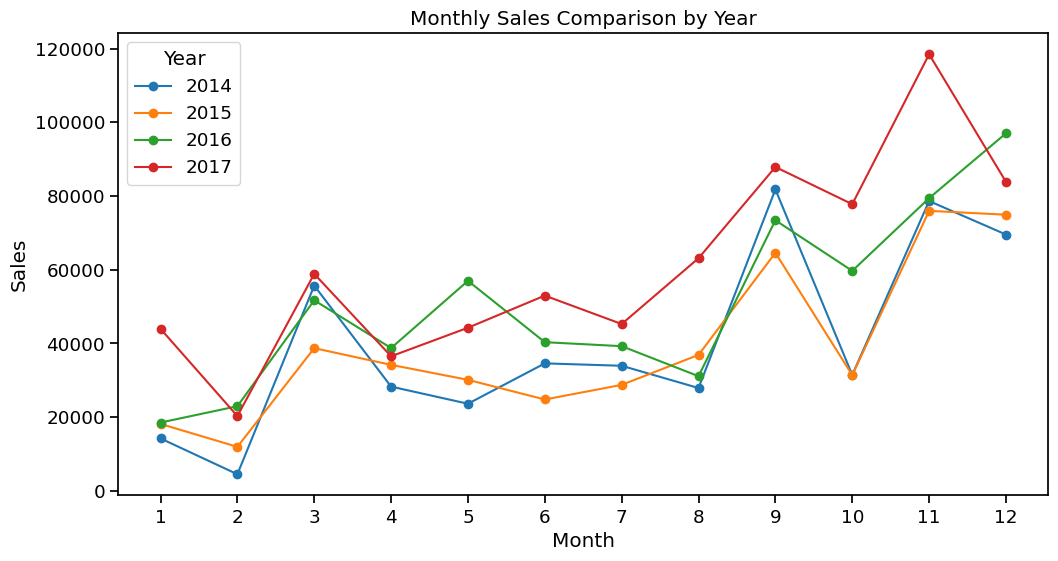

In [150]:
plt.figure(figsize=(12,6))
for year in pivot.columns:
    plt.plot(pivot.index, pivot[year], marker='o', label=str(year))

plt.title('Monthly Sales Comparison by Year')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.xticks(pivot.index)
plt.show()      


compares intra‑year curves month‑by‑month.

Bar Plot 

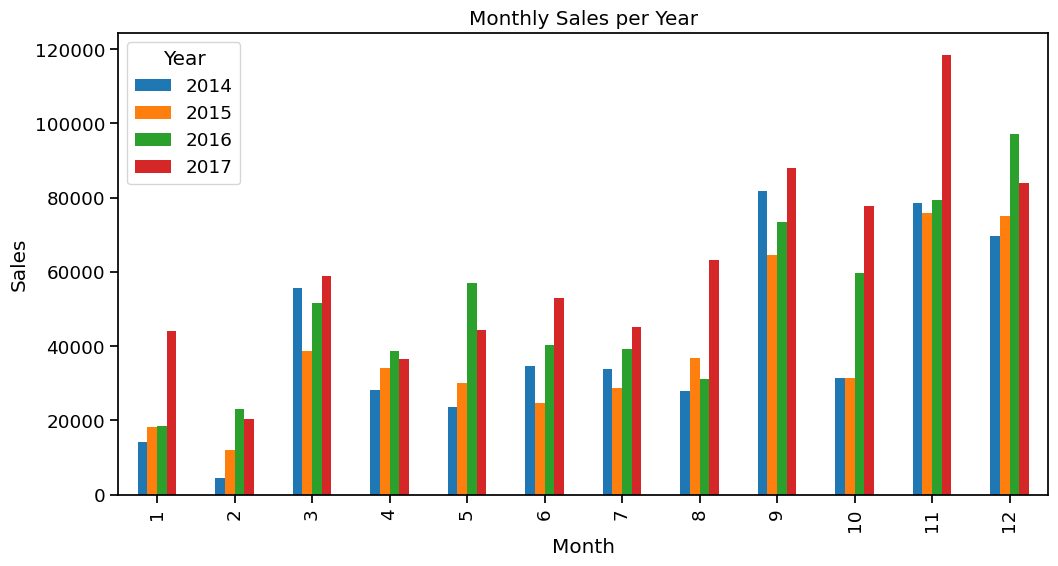

In [151]:
pivot.plot(kind='bar', figsize=(12,6))
plt.title('Monthly Sales per Year')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.show()

stacks months side‑by‑side across years.

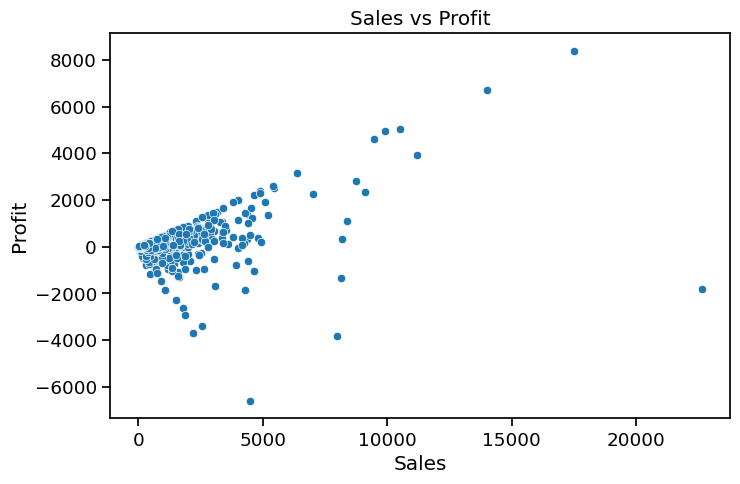

In [152]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Sales', y='Profit', data=df)
plt.title('Sales vs Profit')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.show()


Each point is a line item; the slope/horizontal spread hints whether higher sales typically mean higher profit or if discounting freights margins.

## Analysis Sales by Region

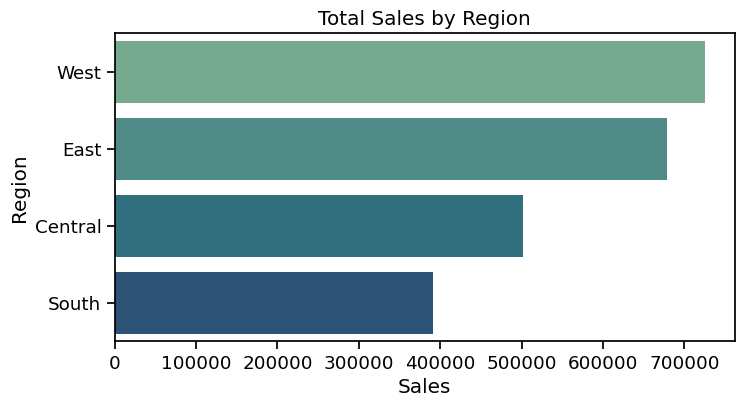

In [153]:
top_regions = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=top_regions.values, y=top_regions.index, palette='crest')
plt.title('Total Sales by Region')
plt.xlabel('Sales')
plt.ylabel('Region')
plt.show()


Regional totals identify footprint strength.

## Analysis Sales by States

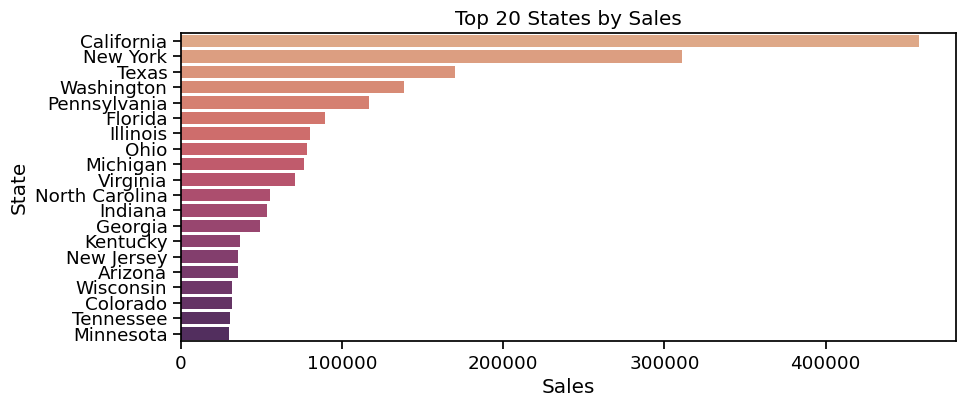

In [154]:
top_States_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10,4))
sns.barplot(x=top_States_sales.values, y=top_States_sales.index, palette='flare')
plt.title('Top 20 States by Sales')
plt.xlabel('Sales')
plt.ylabel('State')
plt.show()

A ranked view of where revenue concentrates.

## Analysis Sales by Cities 

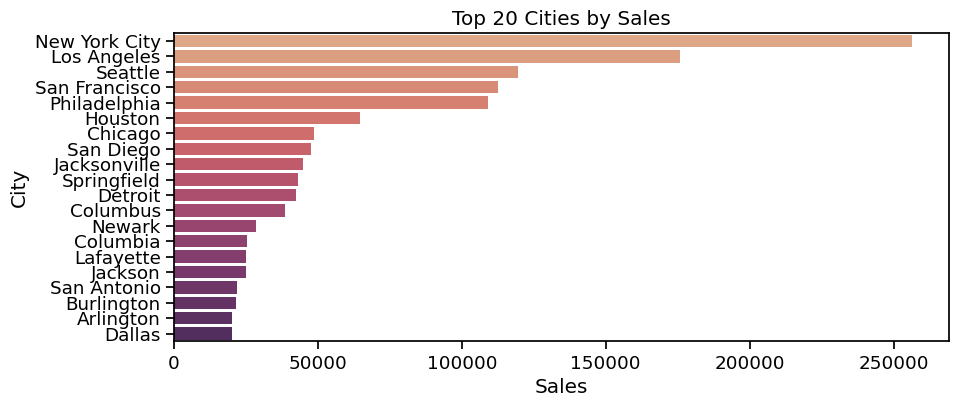

In [155]:
top_Cities_sales = df.groupby('City')['Sales'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10,4))
sns.barplot(x=top_Cities_sales.values, y=top_Cities_sales.index, palette='flare')
plt.title('Top 20 Cities by Sales')
plt.xlabel('Sales')
plt.ylabel('City')
plt.show()


Great inputs for geo‑targeted ads and local partnerships.

## Analysis Profit by States 

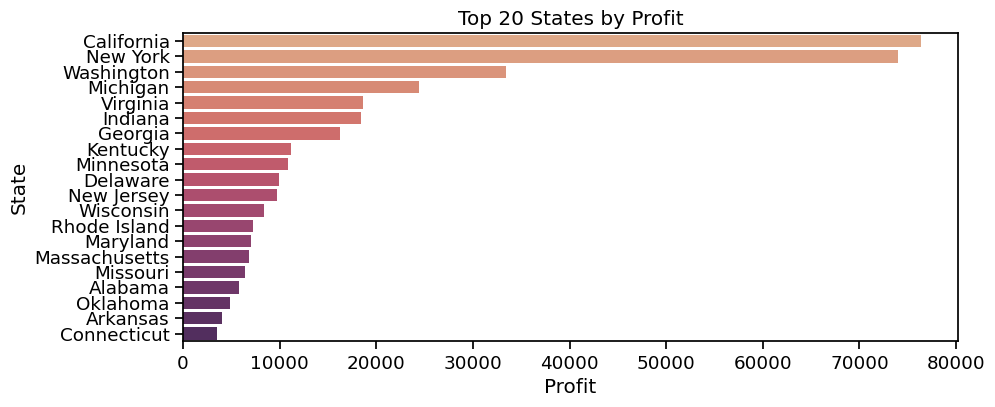

In [156]:
top_States_profit = df.groupby('State')['Profit'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10,4))
sns.barplot(x=top_States_profit.values, y=top_States_profit.index, palette='flare')
plt.title('Top 20 States by Profit')
plt.xlabel('Profit')
plt.ylabel('State')
plt.show()


If a high‑sales state is low‑profit, investigate discount policy, returns, and last‑mile costs.

## Analysis Profit by Cities 

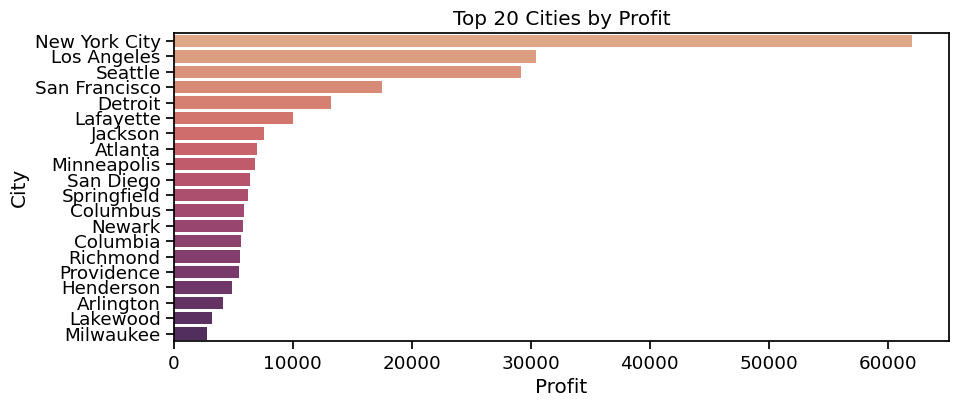

In [157]:
top_Cities_profit = df.groupby('City')['Profit'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10,4))
sns.barplot(x=top_Cities_profit.values, y=top_Cities_profit.index, palette='flare')
plt.title('Top 20 Cities by Profit')
plt.xlabel('Profit')
plt.ylabel('City')
plt.show()


Use this to allocate account managers and service levels where margin justifies investment.

## Category & Sub-Category Sales Analysis

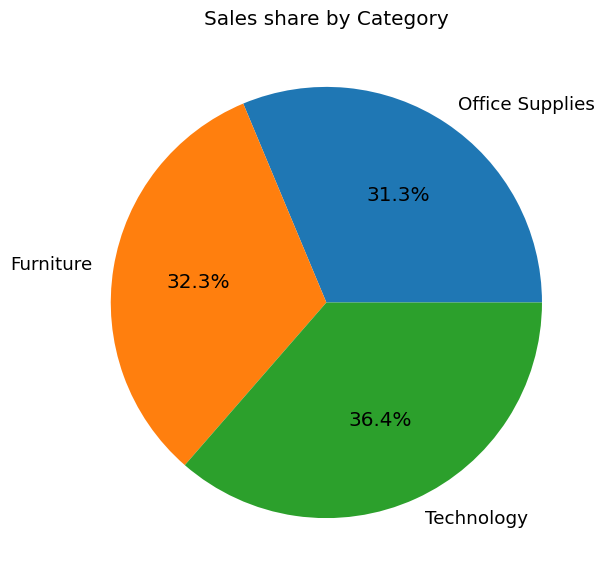

In [158]:
cat_sales = df.groupby('Category')['Sales'].sum().sort_values()
plt.figure(figsize=(10,7))
cat_sales.plot(kind='pie', autopct='%1.1f%%', title='Sales share by Category')
plt.ylabel('')
plt.show()

High‑level composition of revenue by Furniture / Office Supplies / Technology.


## Top Products Word Cloud

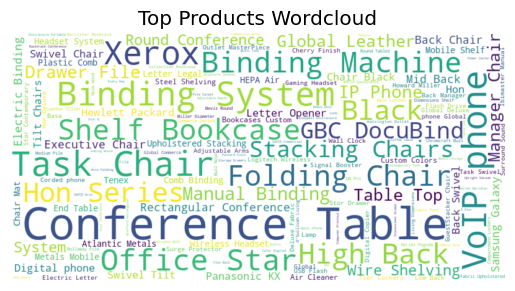

In [159]:
try:
    from wordcloud import WordCloud
    _txt = " ".join(df.loc[df['Sales'] > df['Sales'].quantile(0.75), 'Product Name'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(_txt)
    plt.imshow(wordcloud, interpolation='bilinear'); plt.axis('off'); plt.title("Top Products Wordcloud")
    plt.show()
except Exception as e:
    print("WordCloud skipped →", e)

A quick, qualitative sense of products dominating top‑quartile sales.


## Analysis Profit by Category

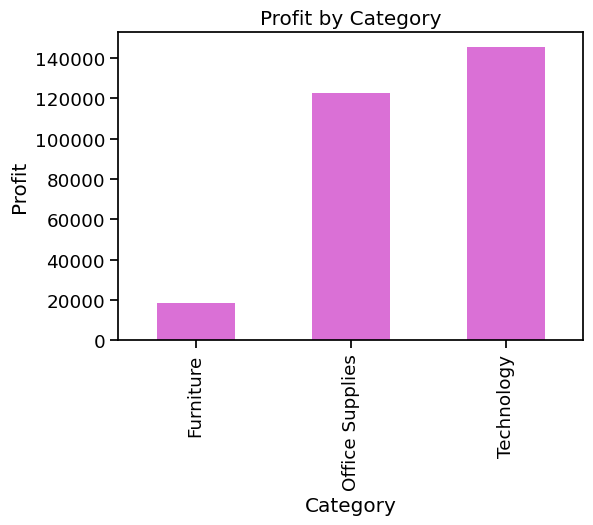

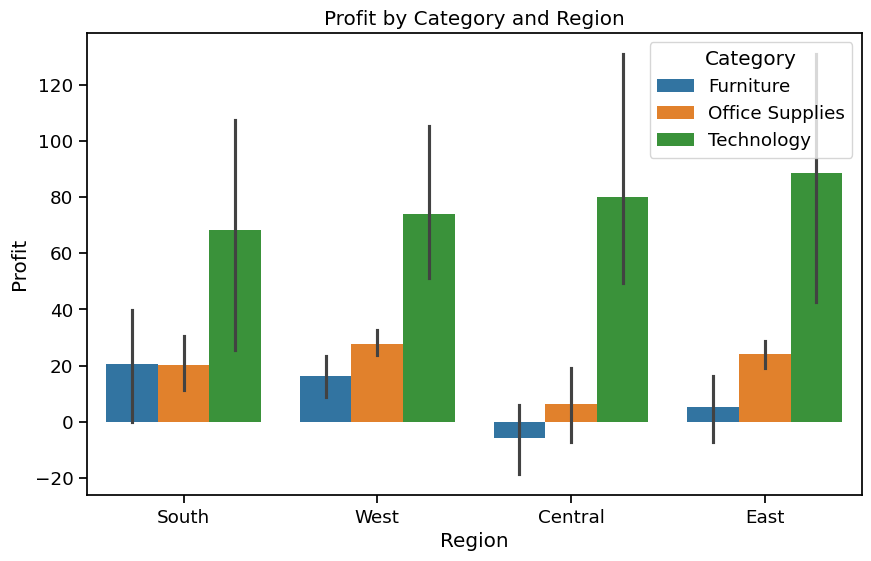

In [160]:
profit_by_category = df.groupby('Category')['Profit'].sum().sort_values()
plt.figure(figsize=(6,4))
profit_by_category.plot(kind='bar', color='orchid', title='Profit by Category')
plt.xlabel('Category'); plt.ylabel('Profit'); plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Region', y='Profit', hue='Category')
plt.title('Profit by Category and Region'); plt.show()

Category bars show margin strength by line.

## Analysis Discount impact on Profit

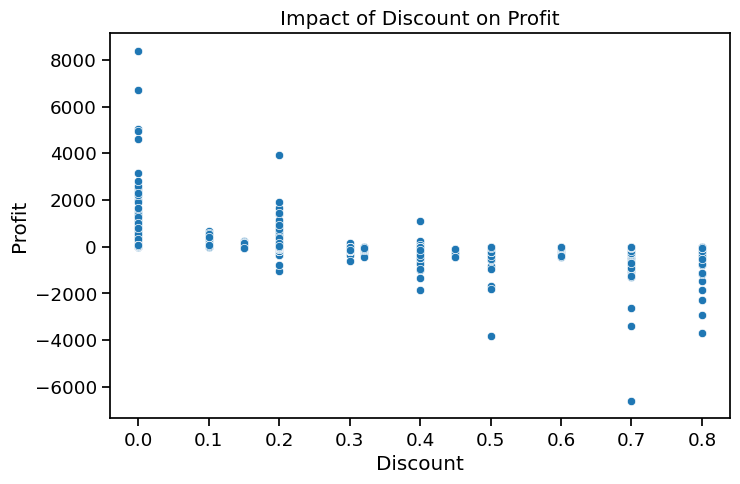

In [161]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='Discount', y='Profit', data=df)
plt.title('Impact of Discount on Profit')
plt.show()

This visual shows whether higher discounts correlate with lower profit.


## Loss-Making Sub-Categories Analysis

In [162]:
loss_products = df.groupby('Sub-Category')['Profit'].sum().sort_values().head(10)
print('Most Loss-Making Sub-Categories:')
loss_products

Most Loss-Making Sub-Categories:


Sub-Category
Tables        -17725.4811
Bookcases      -3472.5560
Supplies       -1189.0995
Fasteners        949.5182
Machines        3384.7569
Labels          5546.2540
Art             6527.7870
Envelopes       6964.1767
Furnishings    13059.1436
Appliances     18138.0054
Name: Profit, dtype: float64

We rank sub‑categories with lowest total profit.


## Profit Distribution

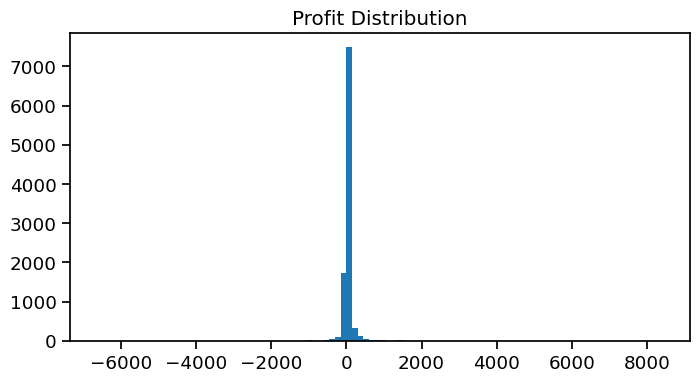

Profit Range: -6599.978 → 8399.976


In [163]:
plt.figure(figsize=(8,4))
plt.hist(df['Profit'], bins=100)
plt.title('Profit Distribution')
plt.show()
print("Profit Range:", df['Profit'].min(), "→", df['Profit'].max())


We check the symmetry and tails of profit at the line level.


## Analysis Top Customers Sales

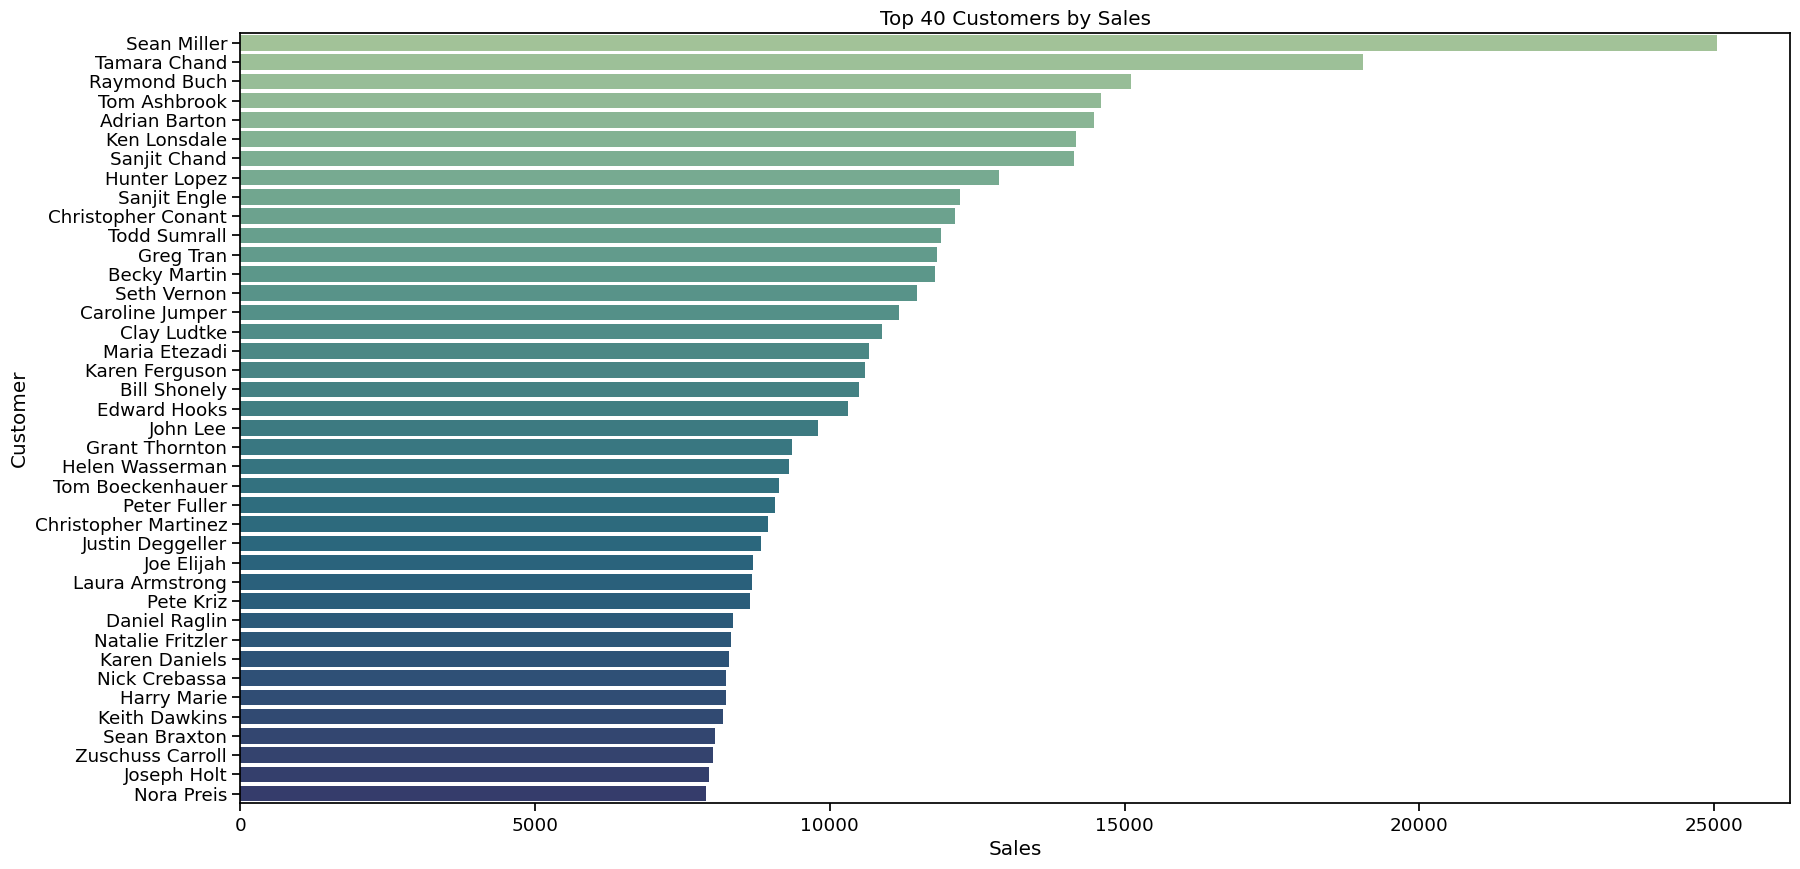

In [164]:
top_customers_sales = df.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).head(40)
plt.figure(figsize=(20,10))
sns.barplot(x=top_customers_sales.values, y=top_customers_sales.index, palette="crest")
plt.title('Top 40 Customers by Sales')
plt.xlabel('Sales')
plt.ylabel('Customer')
plt.show()


Identifies our whales—key for VIP programs, priority support, and contract renewals.

## Analysis Top Customers Profit

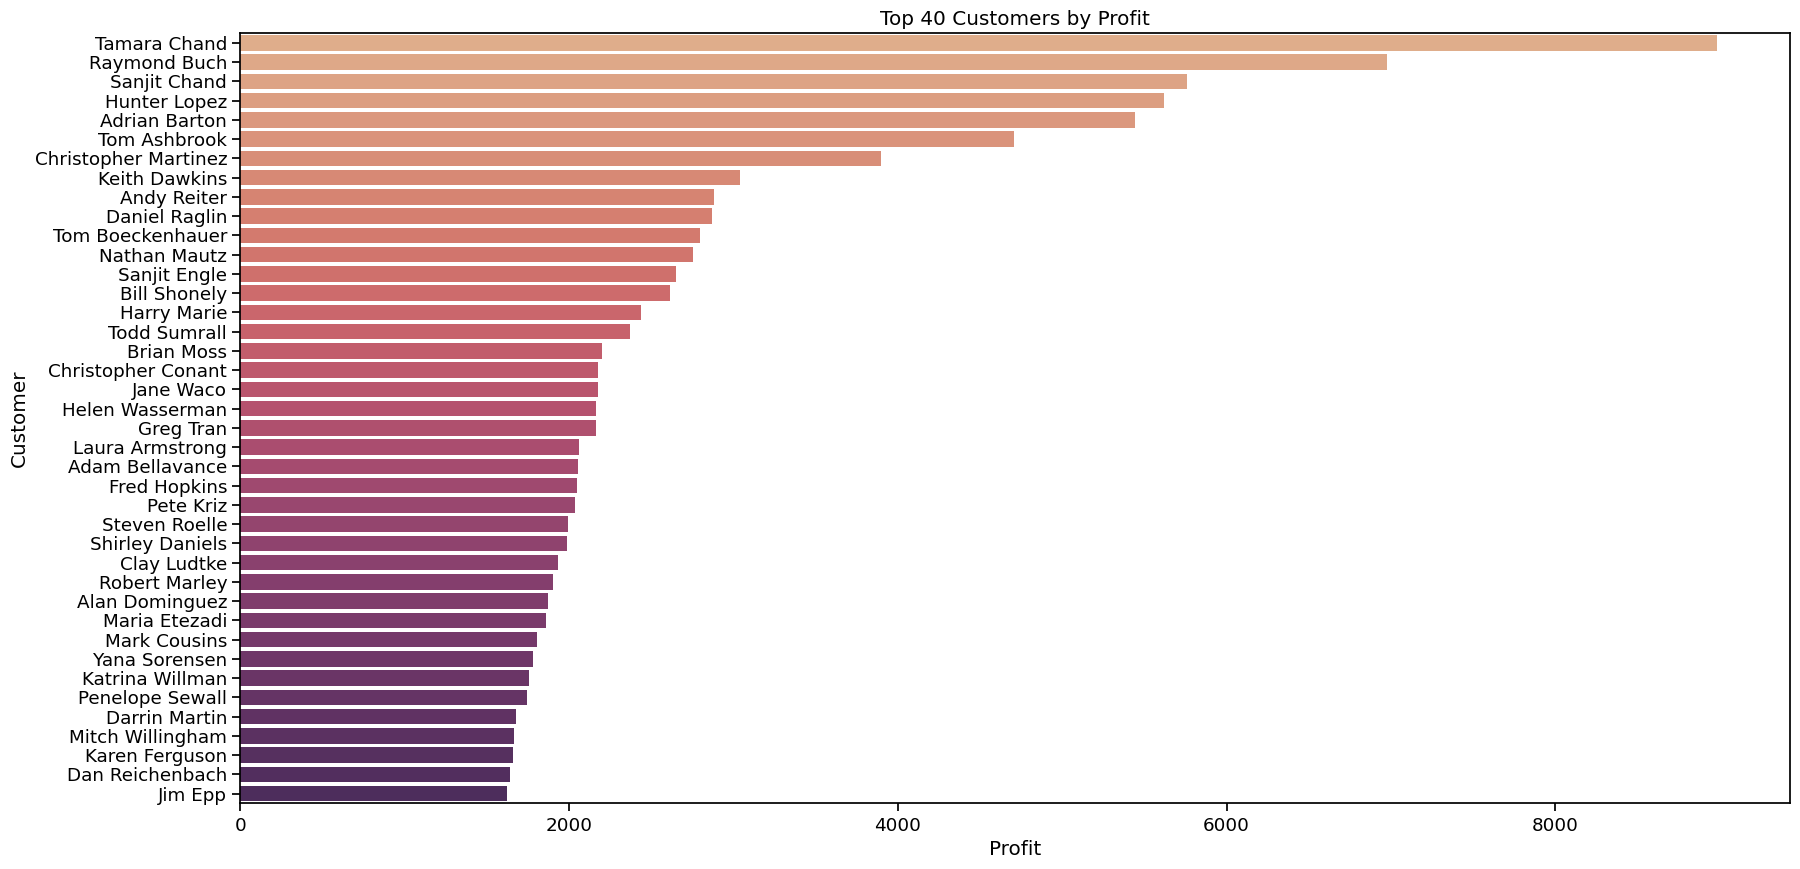

In [165]:
top_customers_profit = df.groupby('Customer Name')['Profit'].sum().sort_values(ascending=False).head(40)
plt.figure(figsize=(20,10))
sns.barplot(x=top_customers_profit .values, y=top_customers_profit .index , palette='flare')
plt.title('Top 40 Customers by Profit')
plt.xlabel('Profit')
plt.ylabel('Customer')
plt.show()

Revenue is vanity, profit is sanity.


## Total Profit Margin by Category

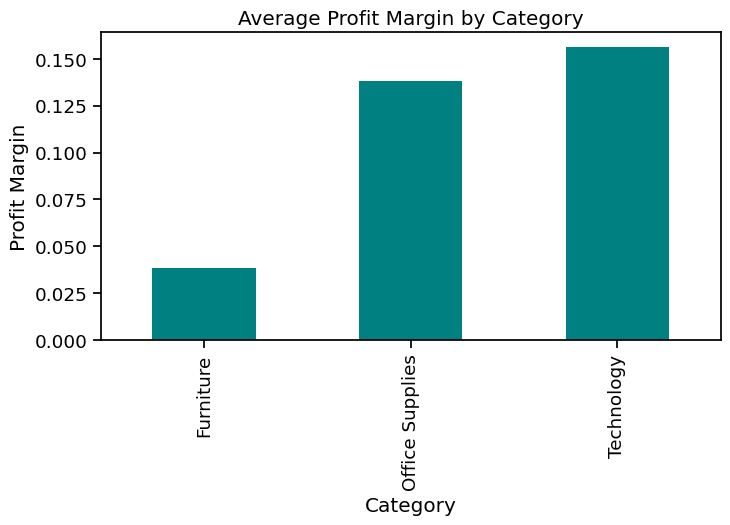

In [166]:
avg_margin_by_cat = (df['Profit'] / df['Sales']).replace([np.inf, -np.inf], np.nan)
margin_by_category = df.assign(_pm=avg_margin_by_cat).groupby('Category')['_pm'].mean().sort_values()
plt.figure(figsize=(8,4))
margin_by_category.plot(kind='bar', color='teal')
plt.title('Average Profit Margin by Category')
plt.ylabel('Profit Margin')
plt.show()


We compute line‑level margin and average by category.


## Total Sales by Sub-Category

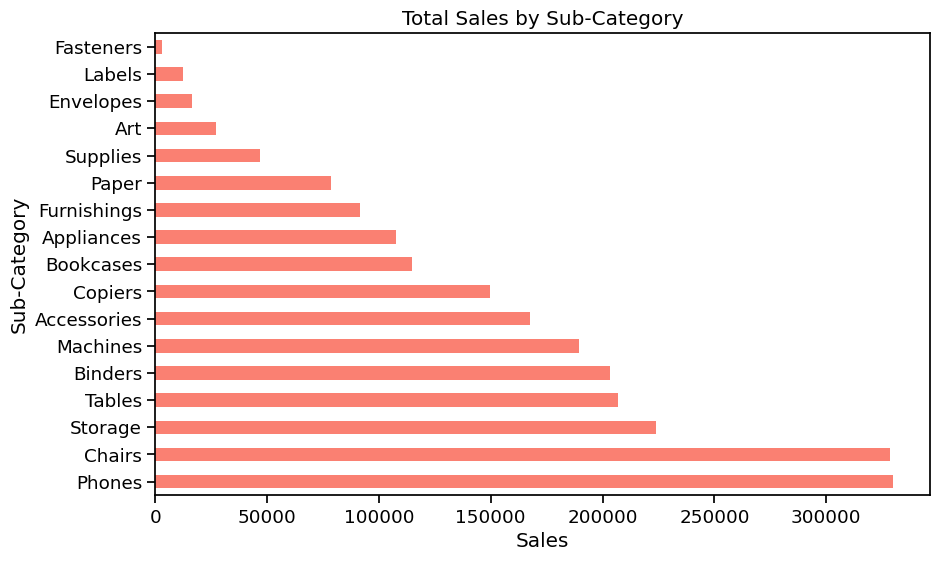

In [167]:
subcat_by_sales = df.groupby('Sub-Category')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
subcat_by_sales.plot(kind='barh', color='salmon')
plt.title('Total Sales by Sub-Category')
plt.xlabel('Sales')
plt.ylabel('Sub-Category')
plt.show()


Great for merchandising decisions and shelf space allocation.

## Total Profit by Sub-Category

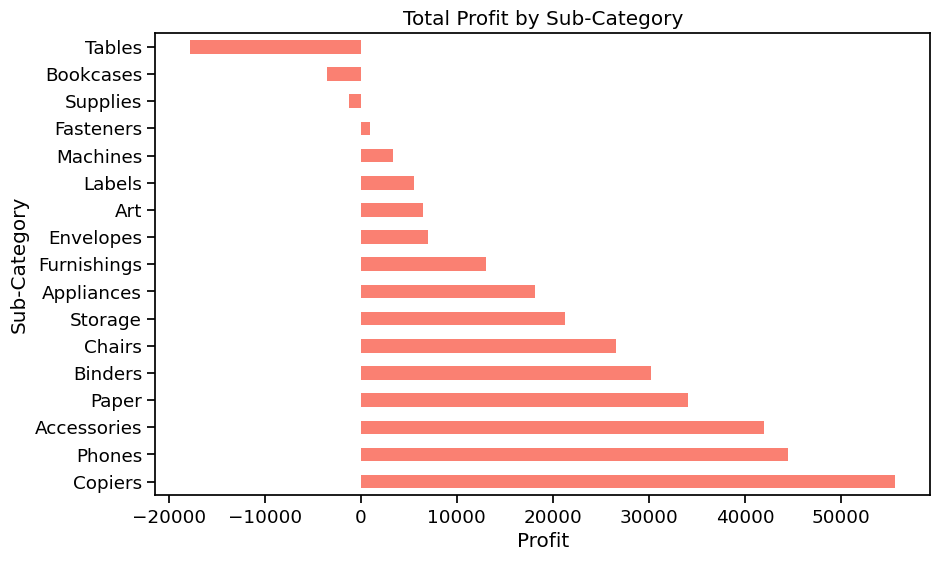

In [168]:
subcat_by_profit = df.groupby('Sub-Category')['Profit'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
subcat_by_profit.plot(kind='barh', color='salmon')
plt.title('Total Profit by Sub-Category')
plt.xlabel('Profit')
plt.ylabel('Sub-Category')
plt.show()


Great for merchandising decisions and shelf space allocation.

## Shipping Time Distribution

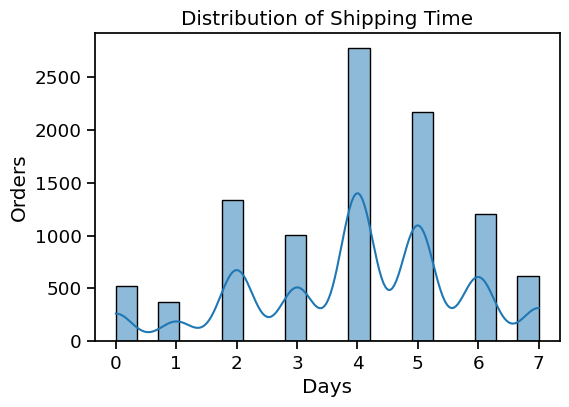

In [169]:
shipping_time = (df['Ship Date'] - df['Order Date']).dt.days.clip(lower=0)
plt.figure(figsize=(6,4))
sns.histplot(shipping_time, bins=20, kde=True)
plt.title('Distribution of Shipping Time')
plt.xlabel('Days')
plt.ylabel('Orders')
plt.show()


Shorter, more predictable shipping improves conversion and reduces returns.


## Yearly Sales/Profit


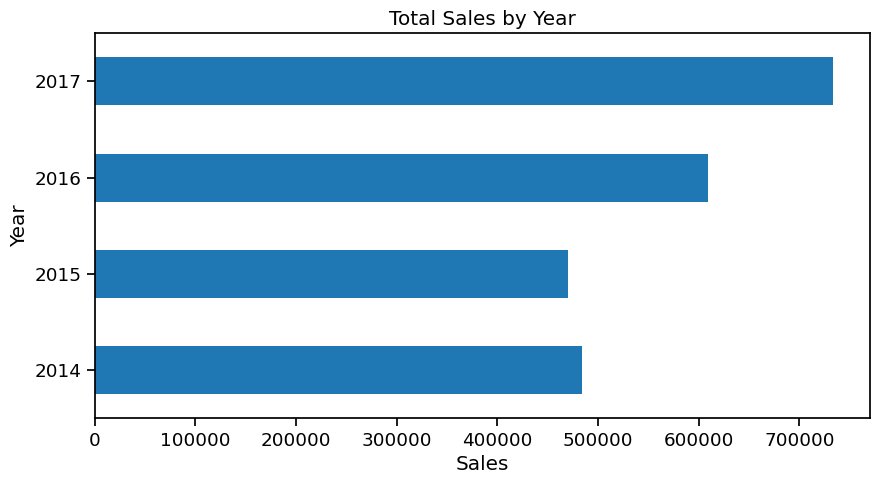

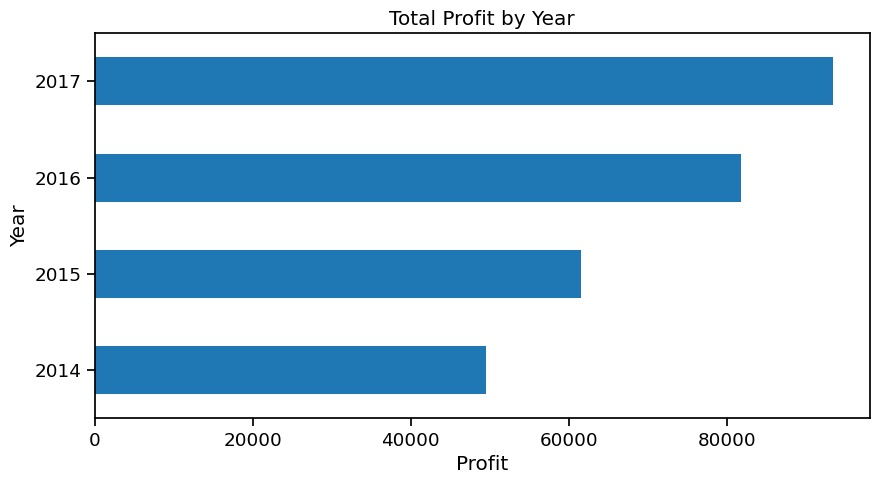

In [170]:
df_year = df.assign(OrderY=df['Order Date'].dt.year)
plt.figure(figsize=(10,5)); df_year.groupby('OrderY')['Sales'].sum().plot.barh()
plt.title('Total Sales by Year'); plt.xlabel('Sales'); plt.ylabel('Year'); plt.show()
plt.figure(figsize=(10,5)); df_year.groupby('OrderY')['Profit'].sum().plot.barh()
plt.title('Total Profit by Year'); plt.xlabel('Profit'); plt.ylabel('Year'); plt.show()

Use alongside seasonality plots for a full temporal story.

## Key Business Metrics (KPIs)

In [171]:
total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()
avg_order_value = df.groupby('Order ID')['Sales'].sum().mean()
total_orders = df['Order ID'].nunique()
unique_customers = df['Customer ID'].nunique()

print(f"Total Sales: {total_sales:,.2f}")
print(f"Total Profit: {total_profit:,.2f}")
print(f"Average Order Value: {avg_order_value:,.2f}")
print(f"Total Orders: {total_orders}")
print(f"Unique Customers: {unique_customers}")


Total Sales: 2,297,200.86
Total Profit: 286,397.02
Average Order Value: 458.61
Total Orders: 5009
Unique Customers: 793


We compute:

Total Sales / Profit

Average Order Value (AOV)

Orders & Unique Customers

This anchors the analysis in a few board‑level metrics.

## Trend Smoothing - Moving Average

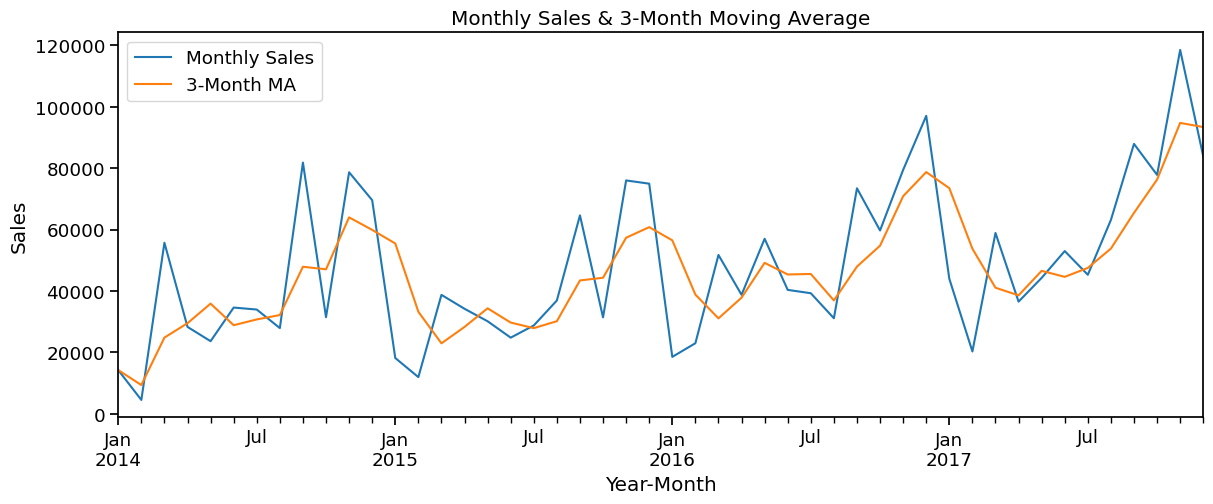

In [172]:
sales_month_smooth = sales_month_by_period.rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(14,5))
sales_month_by_period.plot(label='Monthly Sales')
sales_month_smooth.plot(label='3-Month MA')  
plt.title('Monthly Sales & 3-Month Moving Average')
plt.xlabel('Year-Month'); plt.ylabel('Sales'); plt.legend(); plt.show()


We overlay a 3‑month moving average onto monthly sales.


### Seasonal Decomposition of Sales (Time Series Analysis)

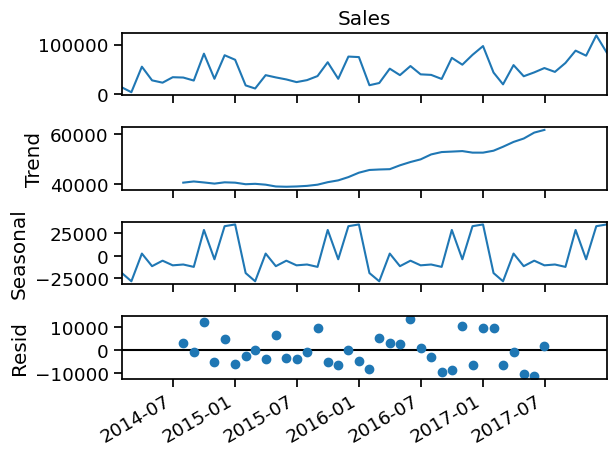

In [173]:
from statsmodels.tsa.seasonal import seasonal_decompose
sales_m = sales_month_by_period.asfreq('M').fillna(0)
res = seasonal_decompose(sales_m, model='additive', period=12)
res.plot(); plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

Perfect for justifying inventory staging and campaign calendars.

## Cohort Analysis – Customer Retention Over Time

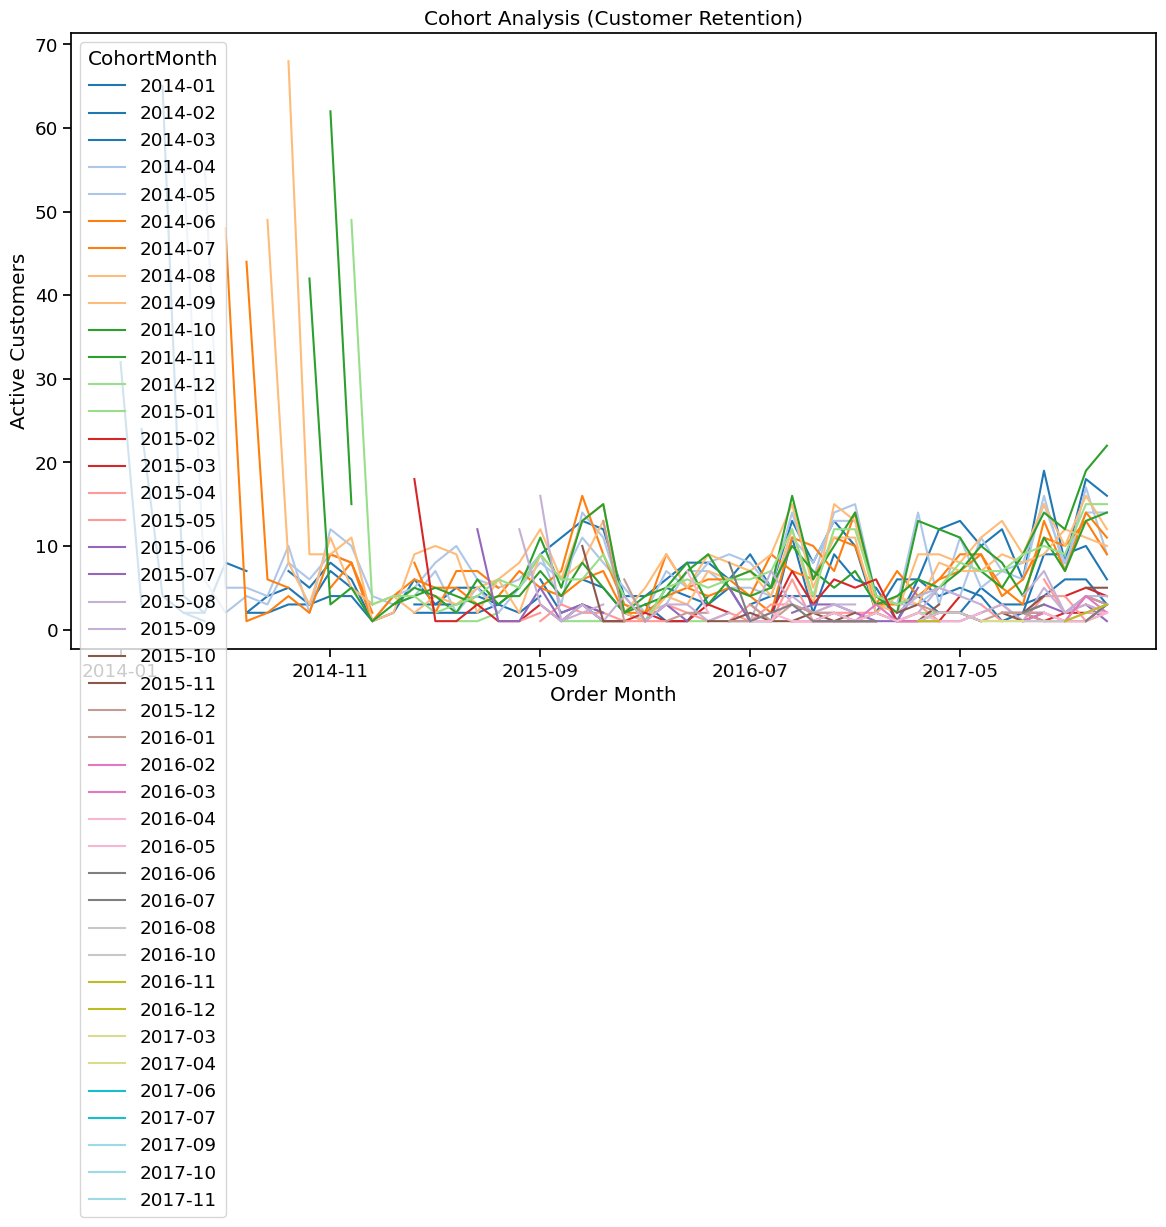

In [174]:
df_cohort = df.copy()
df_cohort['YearMonth'] = df_cohort['Order Date'].dt.to_period('M').astype(str)
df_cohort['CohortMonth'] = df_cohort.groupby('Customer ID')['Order Date'].transform('min').dt.to_period('M').astype(str)
cohort_data = df_cohort.groupby(['CohortMonth','YearMonth'])['Customer ID'].nunique().unstack(0)
cohort_data.plot(figsize=(14,8), cmap='tab20', title='Cohort Analysis (Customer Retention)')
plt.xlabel('Order Month'); plt.ylabel('Active Customers'); plt.show()


Cohort analysis shows strong first-month retention but a drop-off after 3–4 months, indicating need for re-engagement campaigns.

## RFM Analysis

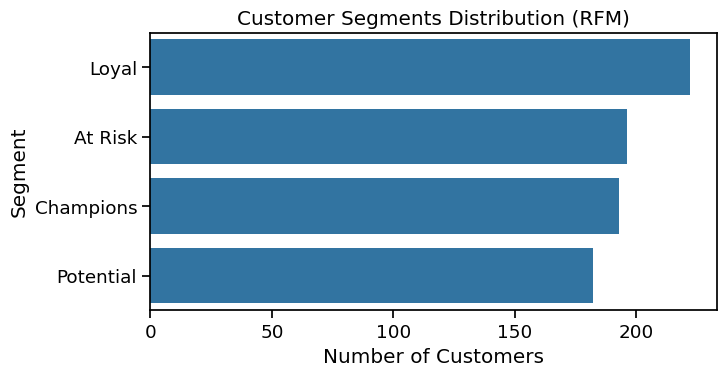

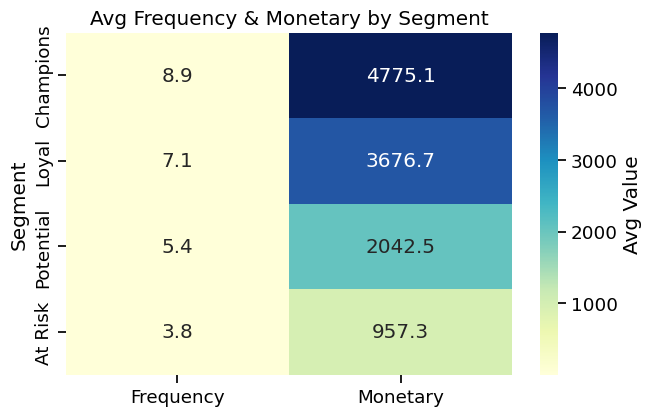

,Recency,Frequency,Monetary
Segment,,,
Champions,36.800000,8.900000,4775.100000
Loyal,92.600000,7.100000,3676.700000
Potential,150.100000,5.400000,2042.500000
At Risk,317.500000,3.800000,957.300000


In [175]:
today = df['Order Date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg(
    Recency  = ('Order Date', lambda x: (today - x.max()).days),
    Frequency=('Order ID', 'nunique'),
    Monetary =('Sales', 'sum')
).reset_index()

# Scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])  # recent=4
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])
rfm[['R_Score','F_Score','M_Score']] = rfm[['R_Score','F_Score','M_Score']].astype(int)
rfm['RFM_Sum'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

def segment_map(score):
    if score >= 10: return 'Champions'
    if score >= 8:  return 'Loyal'
    if score >= 6:  return 'Potential'
    return 'At Risk'
rfm['Segment'] = rfm['RFM_Sum'].apply(segment_map)

# Segment distribution
plt.figure(figsize=(7.5, 4))
sns.countplot(data=rfm, y='Segment',
              order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments Distribution (RFM)')
plt.xlabel('Number of Customers'); plt.ylabel('Segment')
plt.tight_layout(); plt.show()

# Segment KPIs Heatmap
seg_kpis = (rfm.groupby('Segment')[['Recency','Frequency','Monetary']]
              .mean().round(1).sort_values('Monetary', ascending=False))
plt.figure(figsize=(6.8, 4.4))
sns.heatmap(seg_kpis[['Frequency','Monetary']], annot=True, fmt='.1f',
            cmap='YlGnBu', cbar_kws={'label':'Avg Value'})
plt.title('Avg Frequency & Monetary by Segment'); plt.ylabel('Segment')
plt.tight_layout(); plt.show()

# Optional table
try:
    display(seg_kpis.style.background_gradient(cmap='YlGnBu'))
except Exception:
    display(seg_kpis)

# Machine Learning — Predictive Modeling


## Feature Engineering (for ML only)

In [176]:
df_model = df.copy()
df_model['OrderY']             = df_model['Order Date'].dt.year
df_model['OrderM']             = df_model['Order Date'].dt.month
df_model['Discounted Sales']   = df_model['Sales'] * (1 - df_model['Discount'])
df_model['Sales per Quantity'] = (df_model['Sales'] / df_model['Quantity']).replace([np.inf,-np.inf], np.nan)
df_model['Profit Margin']      = (df_model['Profit'] / df_model['Sales']).replace([np.inf,-np.inf], np.nan)
df_model['Shipping Time']      = (df_model['Ship Date'] - df_model['Order Date']).dt.days.clip(lower=0)


We add model‑ready features:

OrderY/OrderM for seasonality

Discounted Sales & Sales per Quantity for price‑sensitivity

Profit Margin (careful: excluded from target leakage)

Shipping Time as an operational driver
We also winsorize profit via 1–99% quantiles to reduce outlier distortion.

## outliers on profit

In [177]:
q_low, q_high = df_model['Profit'].quantile([0.01, 0.99])
df_model = df_model[(df_model['Profit'] > q_low) & (df_model['Profit'] < q_high)].reset_index(drop=True)


## Target & Features

In [178]:
target = "Profit"
drop_cols = [
    "Profit", "Profit Margin",                
    "Order ID","Customer ID","Customer Name",
    "Product ID","Product Name","Postal Code","City","Country",
    "Ship Date","CohortMonth",                          
]
feature_cols = [c for c in df_model.columns if c not in drop_cols]
X = df_model[feature_cols].copy()
y = df_model[target].copy()

Target: Profit

We drop high‑leakage IDs and text columns not useful for prediction.

We remove true datetime objects from X (the model will use extracted year/month instead).

## Remove datetime/period-like from X

In [179]:
datetime_like = X.select_dtypes(include=["datetime64[ns]","timedelta64[ns]","period[M]"]).columns.tolist()
X = X.drop(columns=datetime_like, errors='ignore')


## Identify Types 

In [180]:
numeric_cols     = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
assert len(X) == len(y)


We separate columns by dtype to build type‑specific preprocessors (median impute for numbers, most‑frequent + OHE for categories).

## Preprocessing Encoder 

In [181]:
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=10)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe)])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols) if numeric_cols else ("num","drop",[]),
        ("cat", cat_pipe, categorical_cols) if categorical_cols else ("cat","drop",[]),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

ColumnTransformer applies:

Numeric pipeline: median imputation

Categorical pipeline: most‑frequent imputation + OHE (with handle_unknown='ignore')
This makes the ML pipeline robust to missing values and unseen categories.

## Base model inside Pipeline

In [182]:
rf   = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
pipe = Pipeline([("preprocess", preprocess), ("model", rf)])

We wrap preprocessing + model in one Pipeline.
Benefits: no leakage, repeatable transforms, and clean fit/predict

### Train/Test Split

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


All preprocessing is fitted only on training folds to preserve out‑of‑sample integrity.

## Cross‑Validation (CV)

In [184]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_validate(
    pipe, X_train, y_train,
    cv=cv,
    scoring={"r2":"r2", "rmse":"neg_root_mean_squared_error"},
    n_jobs=-1, return_train_score=False
)
print("\nCV Results:")
print(f"R2  : {cv_scores['test_r2'].mean():.3f} ± {cv_scores['test_r2'].std():.3f}")
print(f"RMSE: {-cv_scores['test_rmse'].mean():.2f} ± {cv_scores['test_rmse'].std():.2f}")



CV Results:
R2  : 0.830 ± 0.008
RMSE: 29.98 ± 1.70


run 5‑fold CV with R² and RMSE to evaluate stability.
Report the mean ± std to understand variance across folds.

## Fit + Test

In [185]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("\nTest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2  :", r2_score(y_test, y_pred))


Test RMSE: 29.16968650303774
Test R2  : 0.8439115238928373


We train on the training set and evaluate on the test set.

RMSE: typical error magnitude in dollars

R²: explanatory power (0–1)
Use both to compare models fairly.

## Feature importance

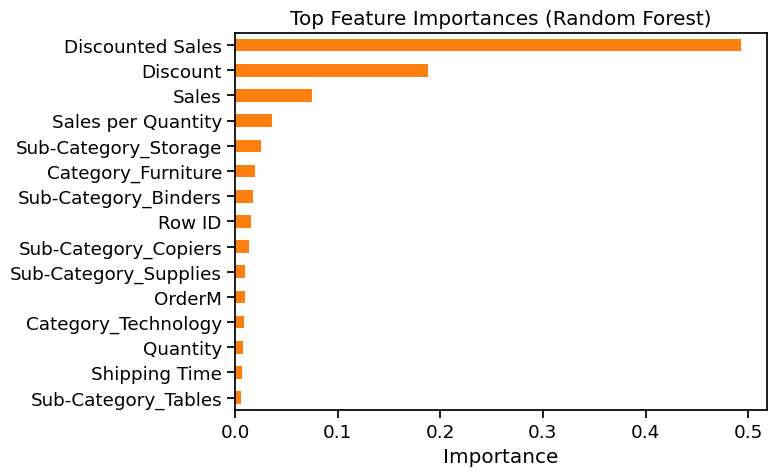

In [186]:
try:
    pre = pipe.named_steps["preprocess"]
    feat_names = pre.get_feature_names_out()
    model = pipe.named_steps["model"]
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
except Exception as e:
    print('RF direct importances unavailable → using permutation_importance. Error:', e)
    perm = permutation_importance(pipe, X_test, y_test, n_repeats=5, n_jobs=-1, random_state=42)
    feat_imp = pd.Series(perm.importances_mean, index=pre.get_feature_names_out()).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_imp.head(15).iloc[::-1].plot(kind='barh', color='tab:orange')
plt.title('Top Feature Importances (Random Forest)'); plt.xlabel('Importance'); plt.ylabel('')
plt.tight_layout(); plt.show()

## Hyperparameter Tuning on GridSearch 

In [187]:
param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
}
grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, scoring="r2", verbose=1)
grid.fit(X_train, y_train)
print("\n[RF Tuned] Best params:", grid.best_params_)
print("[RF Tuned] Best CV R2 :", grid.best_score_)
best_pipe = grid.best_estimator_


Fitting 3 folds for each of 24 candidates, totalling 72 fits

[RF Tuned] Best params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
[RF Tuned] Best CV R2 : 0.8134099184900161


We sweep key RF parameters (trees, depth, split/leaf sizes) to find the best validation R².
Report best params and compare test metrics to the base model.

## XGBoost 

In [188]:
xgb_available = False
try:
    from xgboost import XGBRegressor
    xgb_available = True
    xgb_pipe = Pipeline([
        ("preprocess", preprocess),
        ("xgb", XGBRegressor(
            random_state=42, n_estimators=500, learning_rate=0.05,
            max_depth=6, subsample=0.8, colsample_bytree=0.8, n_jobs=-1
        ))
    ])
    cv_scores_xgb = cross_validate(
        xgb_pipe, X_train, y_train,
        cv=5, scoring={'r2':'r2','rmse':'neg_root_mean_squared_error'},
        n_jobs=-1
    )
    print("\nXGBoost CV:")
    print(f"R2  : {cv_scores_xgb['test_r2'].mean():.3f} ± {cv_scores_xgb['test_r2'].std():.3f}")
    print(f"RMSE: {-cv_scores_xgb['test_rmse'].mean():.2f} ± {cv_scores_xgb['test_rmse'].std():.2f}")

    xgb_pipe.fit(X_train, y_train)
    y_pred_xgb = xgb_pipe.predict(X_test)
    print("XGB Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
    print("XGB Test R2  :", r2_score(y_test, y_pred_xgb))
except Exception as e:
    print("XGBoost skipped →", e)
    xgb_available = False



XGBoost CV:
R2  : 0.848 ± 0.014
RMSE: 28.32 ± 1.86
XGB Test RMSE: 26.23399561567074
XGB Test R2  : 0.8737486006084448


If XGBoost is available, we train a strong gradient‑boosted baseline.
Compare CV and Test metrics with RF; sometimes trees + boosting capture nonlinear interactions better.

## Dynamic Model Performance

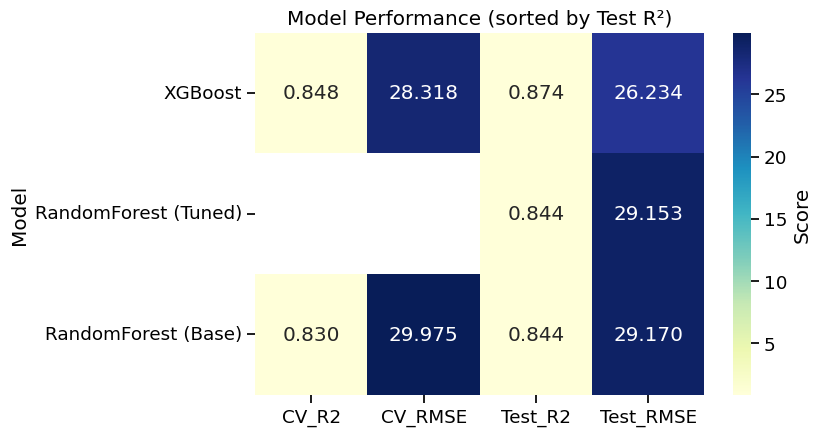

In [189]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rf_cv_r2_mean   = cv_scores['test_r2'].mean()
rf_cv_r2_std    = cv_scores['test_r2'].std()
rf_cv_rmse_mean = -cv_scores['test_rmse'].mean()
rf_cv_rmse_std  = cv_scores['test_rmse'].std()
rf_test_r2      = r2_score(y_test, pipe.predict(X_test))
rf_test_rmse    = mean_squared_error(y_test, pipe.predict(X_test), squared=False)

try:
    rf_tuned_test_r2   = r2_score(y_test, best_pipe.predict(X_test))
    rf_tuned_test_rmse = mean_squared_error(y_test, best_pipe.predict(X_test), squared=False)
    rf_tuned_row = {"CV_R2": np.nan, "CV_R2_std": np.nan,
                    "CV_RMSE": np.nan, "CV_RMSE_std": np.nan,
                    "Test_R2": rf_tuned_test_r2, "Test_RMSE": rf_tuned_test_rmse}
except:
    rf_tuned_row = {"CV_R2": np.nan, "CV_R2_std": np.nan,
                    "CV_RMSE": np.nan, "CV_RMSE_std": np.nan,
                    "Test_R2": np.nan, "Test_RMSE": np.nan}

if xgb_available:
    xgb_cv_r2_mean   = cv_scores_xgb['test_r2'].mean()
    xgb_cv_r2_std    = cv_scores_xgb['test_r2'].std()
    xgb_cv_rmse_mean = -cv_scores_xgb['test_rmse'].mean()
    xgb_cv_rmse_std  = cv_scores_xgb['test_rmse'].std()
    xgb_test_r2      = r2_score(y_test, xgb_pipe.predict(X_test))
    xgb_test_rmse    = mean_squared_error(y_test, xgb_pipe.predict(X_test), squared=False)
else:
    xgb_cv_r2_mean = xgb_cv_r2_std = xgb_cv_rmse_mean = xgb_cv_rmse_std = np.nan
    xgb_test_r2 = xgb_test_rmse = np.nan

perf = pd.DataFrame({
    "Model": ["RandomForest (Base)", "RandomForest (Tuned)", "XGBoost"],
    "CV_R2":   [rf_cv_r2_mean,        rf_tuned_row["CV_R2"],   xgb_cv_r2_mean],
    "CV_R2_std":[rf_cv_r2_std,        rf_tuned_row["CV_R2_std"], xgb_cv_r2_std],
    "CV_RMSE": [rf_cv_rmse_mean,      rf_tuned_row["CV_RMSE"], xgb_cv_rmse_mean],
    "CV_RMSE_std":[rf_cv_rmse_std,    rf_tuned_row["CV_RMSE_std"], xgb_cv_rmse_std],
    "Test_R2": [rf_test_r2,           rf_tuned_row["Test_R2"], xgb_test_r2],
    "Test_RMSE":[rf_test_rmse,        rf_tuned_row["Test_RMSE"], xgb_test_rmse]
}).set_index("Model")

perf_sorted = perf.sort_values("Test_R2", ascending=False)

plt.figure(figsize=(8.5, 4.6))
sns.heatmap(perf_sorted[["CV_R2","CV_RMSE","Test_R2","Test_RMSE"]],
            annot=True, fmt=".3f", cmap='YlGnBu', cbar_kws={"label":"Score"})
plt.title("Model Performance (sorted by Test R²)")
plt.tight_layout(); plt.show()


In [ ]:
from pathlib import Path
import json
import joblib

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Save performance table
try:
    perf_sorted.to_csv(ARTIFACTS_DIR / "model_performance.csv")
except Exception:
    pass

# Pick a "best available" model (simple priority based on what ran)
best_model_name = None
best_model = None

try:
    # prefer the top row in perf_sorted if available
    best_model_name = perf_sorted.index[0]
except Exception:
    best_model_name = "RandomForest (Base)"

if "XGBoost" in str(best_model_name) and "xgb_available" in globals() and xgb_available:
    best_model = xgb_pipe
elif "Tuned" in str(best_model_name) and "best_pipe" in globals():
    best_model = best_pipe
else:
    best_model = pipe

joblib.dump(best_model, ARTIFACTS_DIR / "best_model.joblib")

# Minimal metrics summary (best-effort)
metrics = {"best_model": str(best_model_name)}
try:
    metrics["test_r2_best"] = float(perf_sorted.iloc[0]["Test_R2"])
    metrics["test_rmse_best"] = float(perf_sorted.iloc[0]["Test_RMSE"])
except Exception:
    pass

(ARTIFACTS_DIR / "metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")

print("Saved artifacts to:", ARTIFACTS_DIR.resolve())


### Model Performance  

We compared a RandomForest baseline (and a tuned variant) against XGBoost using 5-fold cross-validation and a held-out test set.

| Model                | CV R² (±std) | CV RMSE (±std) | Test R² | Test RMSE |
|----------------------|--------------|----------------|---------|-----------|
| RandomForest (Base)  | 0.83 ± 0.010 | 29.975 ± 1.78  | 0.844   | 29.17     |
| RandomForest (Tuned) | -            | –              | 0.844   | 29.15     |
| XGBoost              | 0.848 ± 0.017| 28.31 ± 1.97   | 0.874   | 26.23     |

**Result:** XGBoost delivers the best generalization (higher R², lower RMSE). RandomForest tuning did not materially improve over the baseline.

A lower RMSE means smaller average dollar error per line item; moving from ~29.2 to ~26.4 is a meaningful reduction in prediction error.


## XGBoost Feature Importances


In [ ]:
if xgb_available:
    try:
        feat_names = preprocess.get_feature_names_out()
        xgb_model  = xgb_pipe.named_steps['xgb']
        imp = (pd.Series(xgb_model.feature_importances_, index=feat_names)
                 .sort_values(ascending=False)
                 .head(20))
        plt.figure(figsize=(8,5))
        imp.iloc[::-1].plot(kind='barh')
        plt.title('Top 20 Feature Importances (XGBoost)')
        plt.xlabel('Importance'); plt.ylabel('')
        plt.tight_layout(); plt.show()
    except Exception as e:
        print("XGB importances not available →", e)

Helper report_model() prints RMSE and R² in a consistent format so we can compare models apples‑to‑apples.

## Holt-Winters Forecast (Seasonal=12)

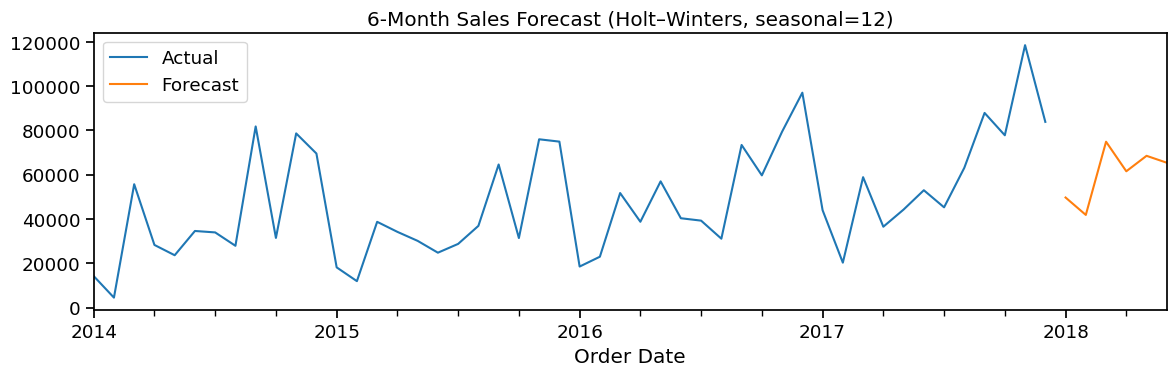

In [197]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

y_series = sales_month_by_period.asfreq('M').fillna(0)
hw = ExponentialSmoothing(y_series, trend='add', seasonal='add', seasonal_periods=12)
hw_fit = hw.fit()
fcast_vals = hw_fit.forecast(6)

future_idx = pd.date_range(y_series.index[-1] + pd.offsets.MonthEnd(1), periods=6, freq='M')
fcast = pd.Series(fcast_vals, index=future_idx)

plt.figure(figsize=(12,4))
y_series.plot(label='Actual')
fcast.plot(label='Forecast')
plt.legend(); plt.title('6-Month Sales Forecast (Holt–Winters, seasonal=12)')
plt.tight_layout(); plt.show()


###  Forecasting (Time Series)

We applied **Holt–Winters Exponential Smoothing (seasonal=12)** to forecast the next 6 months of sales.

- **Result:** December peaks continue, but mid-year growth slows.  
- **Business use:** inventory planning, cash-flow forecasting, and staffing decisions.

**Limitations:**  
While the model captures trend and seasonality, it does not account for:  
- External shocks (economic downturns, pandemics)  
- Marketing campaigns or promotions  
- Changes in product mix or competition

👉 Combine the forecast with domain knowledge and planned events for realistic decisions.


In [195]:
insights_md = f"""
## Executive Insights & Recommendations

- Seasonality peaks in **December**; top months: {", ".join(kpis['top_months_sales'])}.
- **{kpis['highest_region']}** is the strongest region; **{kpis['top_category']}** is the top category by sales.
- Average shipping time ≈ **{kpis['avg_ship_days']:.2f} days** — improving speed/predictability aids conversion & retention.
- RFM suggests a healthy top tier (Champions {rfm_pct['Champions']}%, Loyal {rfm_pct['Loyal']}%) but **At Risk** segment at {rfm_pct['At Risk']}% needs reactivation.
- Pricing/discount policy should be reviewed for loss-making sub-categories (e.g., Tables/Bookcases).
- Deploy the **best model** (per heatmap, typically XGBoost) to score new orders in pricing & margin dashboards.
"""
display(Markdown(insights_md))



## Executive Insights & Recommendations

- Seasonality peaks in **December**; top months: 2017-11, 2016-12, 2017-09, 2017-12, 2014-09.
- **West** is the strongest region; **Technology** is the top category by sales.
- Average shipping time ≈ **3.96 days** — improving speed/predictability aids conversion & retention.
- RFM suggests a healthy top tier (Champions 24%, Loyal 28%) but **At Risk** segment at 25% needs reactivation.
- Pricing/discount policy should be reviewed for loss-making sub-categories (e.g., Tables/Bookcases).
- Deploy the **best model** (per heatmap, typically XGBoost) to score new orders in pricing & margin dashboards.
